In [48]:
#module imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#

#SKLEARN

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

#
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering

from sklearn.metrics import silhouette_score


In [3]:
from google.colab import drive
drive.mount('/content/drive' , force_remount = 'True')
#!ls "/content/drive/My Drive"

Mounted at /content/drive


1. Main objective of the analysis that also specifies whether your model will be focused on clustering or dimensionality reduction and the benefits that your analysis brings to the business or stakeholders of this data :
***The main objective of the analysis is to quantize/cluster the FICO score and assign ratings for loan applications.***

2. Brief description of the data set you chose, a summary of its attributes, and an outline of what you are trying to accomplish with this analysis:
***The data includes FICO scores of 1000 loanee (customer). The goal is to cluster the available FICO scores into buckets and assign them ratings for loan approval.   ***

In [10]:
filepath = "/content/drive/My Drive/Colab Notebooks/Task 3 and 4_Loan_Data.csv"
data = pd.read_csv(filepath)
data['fico_score'].head()

,fico_score
0,605
1,572
2,602
3,612
4,631


3. Brief summary of data exploration and actions taken for data cleaning and feature engineering :
***The data is obtained from a job simulation platform Forage partnered with JP Morgans Chase. The data was checked for any missing or NAN values. The FICO scores distribution is checked by histogramming the data. ***

In [12]:
print (data['fico_score'].shape)
data['fico_score'].info()

(10000,)
<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: fico_score
Non-Null Count  Dtype
--------------  -----
10000 non-null  int64
dtypes: int64(1)
memory usage: 78.3 KB


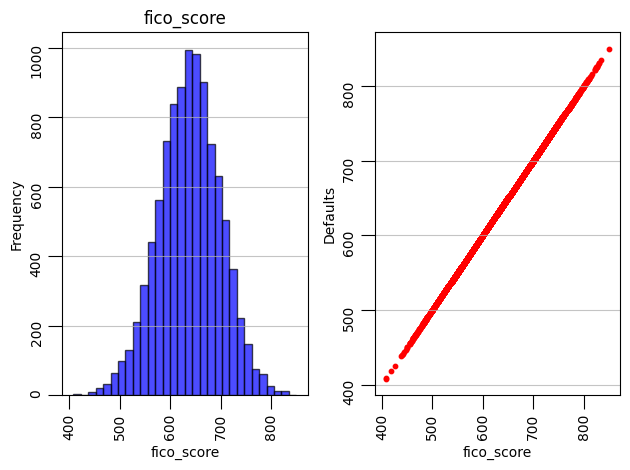

In [18]:
df = data.loc[:, ['fico_score']].copy()
headers = data.columns.tolist()

#PLOTTING
for i in range(len(headers)):
  fig, axes = plt.subplots(1, 2)

  axes[0].hist(df[headers[i]], bins=30, color='blue', edgecolor='black', alpha=0.7)
  axes[0].set_title(headers[i])
  axes[0].set_xlabel(headers[i])
  axes[0].set_ylabel("Frequency")

  axes[0].grid(axis='y', alpha=0.75)
  axes[0].tick_params(size=10, rotation=90)



  axes[1].scatter(df[headers[i]], data[headers[-1]], color='red', marker='o', s=10)
  axes[1].set_xlabel(headers[i])
  axes[1].set_ylabel('Defaults')

  axes[1].grid(axis='y', alpha=0.75)
  axes[1].tick_params(size=10, rotation=90)

  fig.tight_layout()



4. Summary of training at least three variations of the unsupervised model you selected. For example, you can use different clustering techniques or different hyperparameters:

***Four clustering techniques namely KMeans, Gaussian Mixture Models, Spectral and Hierarchical Clustering models were studied to cluster FICO scores into buckets with ratings for loan disbursment. The number of clusters were decided by converging the within-cluster sum of squares or inertia with respect to the number of clusters for Kmeans clustering. ***

Text(0, 0.5, 'SSE')

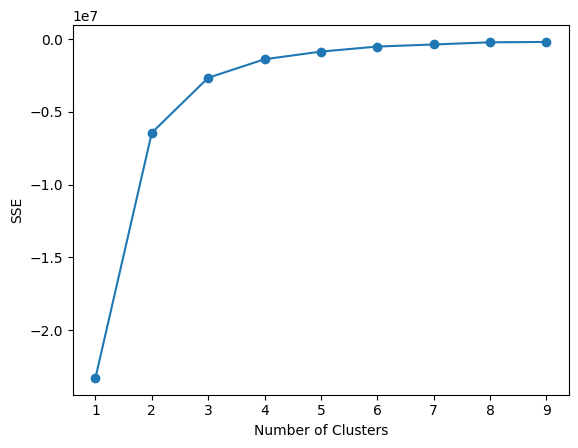

In [23]:
#Kmeans clustering
X = df['fico_score'].values.reshape(-1, 1)
sse=[]
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
  # Compute SSE (inertia_)
  sse.append(kmeans.inertia_)

sse=np.array(sse,float)
plt.plot(range(1,10), np.diff(sse, n=1), marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


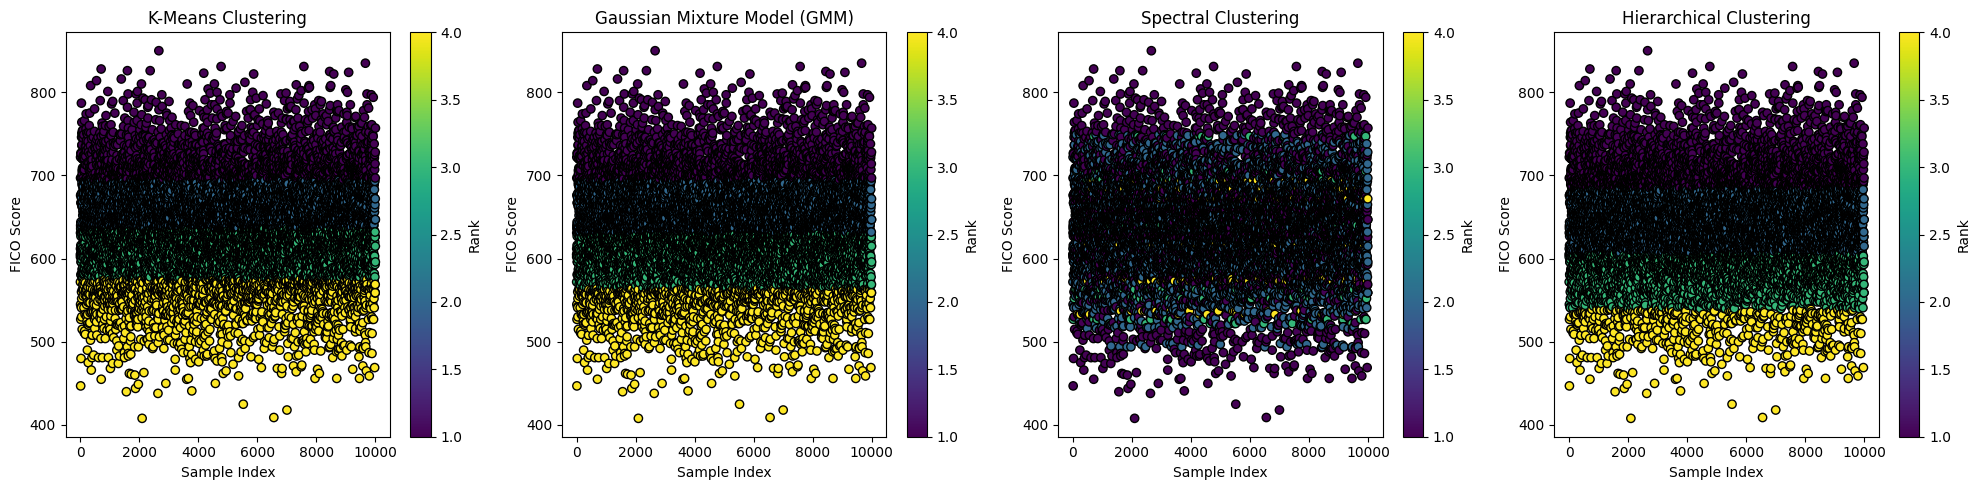

In [43]:
n_clusters = 4
# Scale the data for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['fico_score']])

# K-Means Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(df_scaled)

# Gaussian Mixture Model (GMM) Clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df['GMM_Cluster'] = gmm.fit_predict(df_scaled)

# Spectral Clustering
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df['Spectral_Cluster'] = spectral.fit_predict(df_scaled)

# Hierarchical Clustering (Agglomerative)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
df['Hierarchical_Cluster'] = hierarchical.fit_predict(df_scaled)

# Assign cluster ranks based on maximum fico_score in each cluster
def rank_clusters(df, cluster_col):
    cluster_bounds = df.groupby(cluster_col)['fico_score'].agg(['min', 'max']).sort_values(by='max', ascending=False)
    cluster_bounds['Rank'] = range(1, len(cluster_bounds) + 1)
    rank_map = cluster_bounds['Rank'].to_dict()
    df[cluster_col + '_Rank'] = df[cluster_col].map(rank_map)
    return cluster_bounds

rankings = {}
for algo in ['KMeans_Cluster', 'GMM_Cluster', 'Spectral_Cluster', 'Hierarchical_Cluster']:
    rankings[algo] = rank_clusters(df, algo)

# Plot the results with color bar
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
algorithms = ['KMeans_Cluster', 'GMM_Cluster', 'Spectral_Cluster', 'Hierarchical_Cluster']
titles = ['K-Means Clustering', 'Gaussian Mixture Model (GMM)', 'Spectral Clustering', 'Hierarchical Clustering']

for i, ax in enumerate(axes):
    scatter = ax.scatter(df.index, df['fico_score'], c=df[algorithms[i] + '_Rank'], cmap='viridis', edgecolors='k')
    ax.set_title(titles[i])
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('FICO Score')
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Rank')

plt.tight_layout()
plt.show()



In [45]:
# Display first few rows and cluster boundaries
#print(df.head())
for algo, bounds in rankings.items():
    print(f"Cluster boundaries for {algo}:\n", bounds)

Cluster boundaries for KMeans_Cluster:
                 min  max  Rank
KMeans_Cluster                
1               695  850     1
3               637  694     2
0               576  636     3
2               408  575     4
Cluster boundaries for GMM_Cluster:
              min  max  Rank
GMM_Cluster                
2            695  850     1
1            631  694     2
0            565  630     3
3            408  564     4
Cluster boundaries for Spectral_Cluster:
                   min  max  Rank
Spectral_Cluster                
2                 408  850     1
0                 494  749     2
3                 522  747     3
1                 533  694     4
Cluster boundaries for Hierarchical_Cluster:
                       min  max  Rank
Hierarchical_Cluster                
2                     685  850     1
0                     607  684     2
1                     540  606     3
3                     408  539     4


In [49]:
# Calculate Silhouette Scores
silhouette_scores = {
    'KMeans': silhouette_score(df_scaled, df['KMeans_Cluster']),
    'GMM': silhouette_score(df_scaled, df['GMM_Cluster']),
    'Spectral': silhouette_score(df_scaled, df['Spectral_Cluster']),
    'Hierarchical': silhouette_score(df_scaled, df['Hierarchical_Cluster'])
}

print("\nSilhouette Scores:")
for algo, score in silhouette_scores.items():
    print(f"{algo}: {score}")


Silhouette Scores:
KMeans: 0.521005158424076
GMM: 0.5204001542216838
Spectral: -0.04897921707948123
Hierarchical: 0.5088051911636771


5. A paragraph explaining which of your Unsupervised Learning models you recommend as a final model that best fits your needs in terms.

***The four models: KMeans, GMMM, Spectral, Heirarchial. The four methids clustered the data into 4 rating tranches with rank 1 being the customer with high FICO score and less adverse to defaults. Out of the four models, spectral clustering seems most ineefient while the others faired better with similar silhouette score and visual separation. For this system, Kmeans is the best model with computationally less intensive, simple and and also has the best comparitive score. ***

6. Summary Key Findings and Insights, which walks your reader through the main findings of your modeling exercise.:

***FICO scores are one of the metrics for offering loan to customers. Clustering allows the bank to identify the customers in different buckets and accordingly provide loan committments. This is very important from the risk point of view as loan defaults and FICO are proportional.***

7. Suggestions for next steps in analyzing this data, which may include suggesting revisiting this model or adding specific data features to achieve a better model.

***Much could be improved in terms of clustering by recalculating the no. of clusters for each model. New error metrics for the clustering could be introduced to optimize the process better. In addition, more data could be sampled for better clustering. ***